This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: TODO). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
import convokit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [2]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus-small"))

We will compute features over only the first 10 comments that occur in a thread, for  threads which are at least 10 comments long (controling for thread length in this way):

In [3]:
threads = corpus.utterance_threads(prefix_len=10)

In [4]:
def display_thread_helper(thread, root, indent=0):
    print(" "*indent + thread[root].user.name)
    children = [k for k, v in thread.items() if v.reply_to == root]
    for child in children:
        display_thread_helper(thread, child, indent=indent+4)
def display_thread(root):
    return display_thread_helper(threads[root],root)

The following are threads that come from the /r/canada subreddit. 

In [5]:
demo_threads = [
    # https://www.reddit.com/r/canada/comments/mmyld/polygamypolyamoury_laws_upheld_in_supreme_court/c32bcq8/
                't1_c32bcq8', 
    # https://www.reddit.com/r/canada/comments/mmd20/look_what_i_found_today_yes_and_it_is_in_canada/c322oa7/
                't1_c322oa7',
    # https://www.reddit.com/r/canada/comments/mo0lt/happy_thursday/c32hv0h/
                't1_c32hv0h'
               ]

We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, TODO.

In [6]:
for thread in demo_threads:
    print(thread)
    print('---')
    display_thread(thread)
    print()

t1_c32bcq8
---
drays
    QuirkyGroundhog
        Sajentine
            QuirkyGroundhog
                drays
                    QuirkyGroundhog
                        drays
                            QuirkyGroundhog
                                drays
                                    QuirkyGroundhog

t1_c322oa7
---
[deleted-t1_c322oa7]
    Aneeid
    veedubbin86
        figureskatingaintgay
            sirspate
        lovevolcano
    bunny1979
        veedubbin86
            bunny1979
    SoFaKiNg42

t1_c32hv0h
---
Can-eh-dian
    h00pla
        Switchbladeannie
        lengthynewt
            h00pla
                lengthynewt
                    h00pla
    thoriginal
    lengthynewt
    andrewmp



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.

We now extract hypergraph features. 

In [7]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo(corpus)
threads_feats = hc.retrieve_feats()

In [8]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [9]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [10]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:

In [11]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

Here are some examples of features computed over the three example threads from before:

In [12]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution. 

As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [13]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[indegree over C->C responses],0.000000,2.000000,1.000000
2nd-largest / max[indegree over C->C responses],0.500000,0.750000,0.500000
2nd-largest[indegree over C->C responses],1.000000,3.000000,2.000000
argmax[indegree over C->C responses],1.000000,0.000000,0.000000
entropy[indegree over C->C responses],1.039721,1.214890,0.955700
max[indegree over C->C responses],2.000000,4.000000,4.000000
mean-nonzero[indegree over C->C responses],1.333333,2.250000,2.333333
mean[indegree over C->C responses],1.333333,1.125000,1.166667
norm.2nd-largest[indegree over C->C responses],0.250000,0.333333,0.285714
norm.max[indegree over C->C responses],0.500000,0.444444,0.571429


Features derived from the distribution of hypernode to hypernode outdegrees in the _middle_ of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?"). 

In [14]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
2nd-argmax[outdegree over C->C mid-thread responses],1.000000,2.000000,1.000000
2nd-largest / max[outdegree over C->C mid-thread responses],0.500000,1.000000,1.000000
2nd-largest[outdegree over C->C mid-thread responses],1.000000,1.000000,1.000000
argmax[outdegree over C->C mid-thread responses],0.000000,1.000000,0.000000
entropy[outdegree over C->C mid-thread responses],1.039721,1.609438,1.098612
max[outdegree over C->C mid-thread responses],2.000000,1.000000,1.000000
mean-nonzero[outdegree over C->C mid-thread responses],1.333333,1.000000,1.000000
mean[outdegree over C->C mid-thread responses],1.333333,0.714286,0.600000
norm.2nd-largest[outdegree over C->C mid-thread responses],0.250000,0.200000,0.333333
norm.max[outdegree over C->C mid-thread responses],0.500000,0.200000,0.333333


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features _counts_ of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [15]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
count[dyadic interaction motif],4,2,2
count[external reciprocity motif],2,4,2
count[incoming triads],1,9,7
count[outgoing triads],28,17,23
count[reciprocity motif],6,1,3


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space. 

In [16]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [17]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [18]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [19]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:

In [20]:
U_df.loc[demo_threads].T

,t1_c32bcq8,t1_c322oa7,t1_c32hv0h
0,-0.777232,0.531228,0.294587
1,0.103506,-0.027301,0.382833
2,-0.156619,-0.124054,0.422262
3,0.013446,-0.439604,-0.146495
4,-0.166990,-0.077787,0.231274
5,0.504467,0.638140,0.672861
6,0.279489,-0.308443,-0.246297


As well as embeddings of features:

In [47]:
V_df.loc[C_C_indegree_feats]

,0,1,2,3,4,5,6
max[indegree over C->C responses],0.707398,0.261800,-0.147295,0.498275,-0.259565,-2.035341e-16,0.306105
argmax[indegree over C->C responses],-0.002068,-0.574601,0.205056,0.111429,-0.497820,4.682036e-15,0.606251
norm.max[indegree over C->C responses],0.135637,0.613915,0.565356,0.346540,-0.391737,-2.244253e-15,0.107401
2nd-largest[indegree over C->C responses],0.294020,-0.628702,0.093639,-0.109596,0.394505,-3.949454e-15,-0.584698
2nd-argmax[indegree over C->C responses],0.208335,0.155052,-0.302585,-0.186735,0.440548,-8.185549e-15,-0.782333
norm.2nd-largest[indegree over C->C responses],-0.235425,-0.000673,0.688796,-0.333940,0.272608,-5.409284e-15,-0.533202
mean[indegree over C->C responses],-0.242336,-0.197210,-0.259327,0.853324,0.325546,1.088834e-16,-0.031442
mean-nonzero[indegree over C->C responses],0.582478,0.144709,0.489760,0.467188,0.141005,2.227738e-15,0.402202
prop-nonzero[indegree over C->C responses],-0.869691,-0.014780,-0.381007,0.276672,0.146451,5.854121e-16,-0.016050
prop-multiple[indegree over C->C responses],0.351108,-0.469028,0.409616,0.360764,0.595355,2.275226e-16,-0.065969


As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [21]:
subreddits = []
for thread_id in U_df.index:
    subreddits.append(corpus.utterances[thread_id].user.info['subreddit'])
U_df['subreddit'] = subreddits

In [22]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [23]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

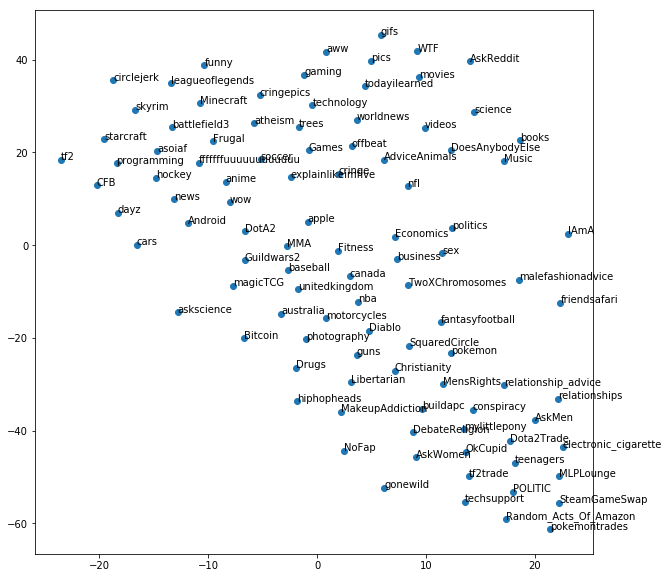

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

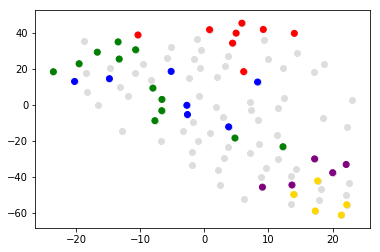

In [49]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB",  "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = [ "AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [26]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [27]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [28]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                       p2      dist
3622                  MMA  0.007002
3618           Guildwars2  0.008068
3601              Android  0.015153
3651               cringe  0.020005
3647               canada  0.020143
3655    explainlikeimfive  0.021395
3611                DotA2  0.023175
3615              Fitness  0.024131
3687               soccer  0.025013
3657  fffffffuuuuuuuuuuuu  0.025947

politics
              p2      dist
8085         sex  0.011510
8046    business  0.023910
8047      canada  0.024544
8015     Fitness  0.027869
8036       apple  0.028545
8018  Guildwars2  0.028934
8001     Android  0.029631
8040   australia  0.031831
8014   Economics  0.031963
8051      cringe  0.034063

leagueoflegends
                       p2      dist
6686               skyrim  0.010648
6659                funny  0.011909
6643         battlefield3  0.021485
6652           cringepics  0.021545
6694        todayilearned  0.024015
6649           circlejerk  0.028975
6625            Minecr

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [30]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [31]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c2w6jv0,-0.821721,0.114695,0.048006,0.298202,0.083974,0.448085,0.112069,pokemontrades
t1_c2z5mua,-0.821692,0.133362,0.065251,0.303148,0.081658,0.441862,0.094716,Drugs
t1_c311r7d,-0.809397,0.210159,0.234888,0.206114,-0.006492,0.433126,0.124158,programming
t1_c31hpo4,-0.809397,0.210159,0.234888,0.206114,-0.006492,0.433126,0.124158,techsupport
t1_c0o1i2y,-0.807628,0.218595,0.243568,0.207655,-0.007977,0.429525,0.113806,pokemontrades
t1_c31rw5i,-0.807628,0.218595,0.243568,0.207655,-0.007977,0.429525,0.113806,trees
t1_c5onr62,-0.800961,0.221687,0.181993,0.302325,-0.012371,0.428920,0.025871,Random_Acts_Of_Amazon
t1_c3b51sj,-0.800961,0.221687,0.181993,0.302325,-0.012371,0.428920,0.025871,SteamGameSwap
t1_c3bapea,-0.800961,0.221687,0.181993,0.302325,-0.012371,0.428920,0.025871,SteamGameSwap
t1_c1w5imz,-0.800961,0.221687,0.181993,0.302325,-0.012371,0.428920,0.025871,tf2trade


,0,1,2,3,4,5,6
prop-nonzero[indegree over C->C mid-thread responses],-0.892606,-0.003984,-0.367540,0.238804,0.105175,7.706408e-16,0.007981
prop-nonzero[indegree over C->C responses],-0.869691,-0.014780,-0.381007,0.276672,0.146451,5.854121e-16,-0.016050
count[reciprocity motif],-0.833318,0.273780,0.434544,0.170330,-0.093962,-1.579597e-15,-0.062891
is-present[reciprocity motif over mid-thread],-0.832150,-0.334924,-0.111952,0.394521,0.149140,-5.588456e-16,0.070214
entropy[indegree over C->c responses],-0.830402,-0.243616,-0.324573,-0.368319,-0.066445,3.077858e-15,0.075254
entropy[indegree over c->c responses],-0.830402,-0.243616,-0.324573,-0.368319,-0.066445,3.036819e-15,0.075254
count[reciprocity motif over mid-thread],-0.829365,0.205091,0.486489,-0.095247,-0.151648,-1.745562e-16,0.036749
prop-nonzero[indegree over c->c responses],-0.825113,-0.001947,-0.317472,-0.352459,-0.217080,1.866574e-15,0.216900
prop-nonzero[indegree over C->c mid-thread responses],-0.825113,-0.001947,-0.317472,-0.352459,-0.217080,3.114638e-16,0.216900
prop-nonzero[indegree over c->c mid-thread responses],-0.825113,-0.001947,-0.317472,-0.352459,-0.217080,4.398992e-16,0.216900


,0,1,2,3,4,5,6
subreddit,,,,,,,
Random_Acts_Of_Amazon,-0.698104,0.345358,0.261602,-0.194193,-0.064299,0.532066,-0.001825
SteamGameSwap,-0.680920,0.299392,0.266069,0.065980,-0.061866,0.605953,-0.023668
techsupport,-0.651063,0.112806,0.246119,-0.106444,-0.056593,0.697155,0.047538
MLPLounge,-0.648858,0.184042,0.054745,0.045370,0.012583,0.734635,0.014491
POLITIC,-0.637987,0.176037,0.234424,-0.027947,-0.009663,0.708990,-0.059059
pokemontrades,-0.615748,0.330811,0.509647,-0.244727,-0.148778,0.408140,-0.055446
tf2trade,-0.592484,0.086138,0.192252,0.068415,-0.005123,0.773100,0.046825
Dota2Trade,-0.581859,-0.072666,0.069570,0.121610,-0.005124,0.797371,-0.026552
electronic_cigarette,-0.575098,-0.005657,0.079479,0.261555,-0.107226,0.763515,-0.007072


In [32]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c2w6jv0
icouldgetlost
    normanlman
        selref
            normanlman
                selref
                    normanlman
                        selref
                            selref
                                normanlman
                                    selref

t1_c2z5mua
pinkflowers
    reginaldfairfield
        [deleted-t1_c2z5mua]
            reginaldfairfield
                [deleted-t1_c2z5mua]
                    reginaldfairfield
                        [deleted-t1_c2z5mua]
                            reginaldfairfield
                                [deleted-t1_c2z5mua]
                                    [deleted-t1_c2z5mua]

t1_c311r7d
Ralith
    homoiconic
        Ralith
            homoiconic
                homoiconic
                    Ralith
                        homoiconic
                            Ralith
                                homoiconic
                                    Ralith

t1_c31hpo4
snoobie
    jakeh111
        snoobie
    

In [33]:
top_threads = display_dimension(0, ascending=False, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c30s6fg,0.776081,0.382248,0.263532,-0.219980,0.035686,0.359229,-0.058530,pics
t1_c2wmft1,0.773361,0.399488,0.245694,-0.231841,-0.015995,0.357607,0.008216,relationship_advice
t1_c332bij,0.773133,0.394426,0.222535,-0.239036,0.129048,0.345987,-0.060604,AdviceAnimals
t1_c30xu14,0.772908,0.387760,0.278649,0.019592,0.141217,0.392347,-0.018630,technology
t1_c319lte,0.770920,0.424730,0.179297,-0.073461,0.042430,0.359831,-0.237623,photography
t1_c30s5kg,0.770600,0.408164,0.281400,-0.111299,-0.014361,0.383958,0.019357,pics
t1_c2xf0ag,0.767846,0.435489,0.268989,-0.047938,0.047053,0.371585,-0.076290,apple
t1_c2zcvzz,0.765407,0.406737,0.334511,-0.043045,-0.009161,0.362238,0.060549,Economics
t1_c2zzq1w,0.764955,0.446708,0.243906,-0.009920,-0.013683,0.344620,-0.191721,wow
t1_c30tnm9,0.764722,0.405784,0.283069,0.052876,0.093483,0.396327,-0.042443,technology


,0,1,2,3,4,5,6
count[incoming triads],0.789860,0.299836,0.099630,0.406792,-0.081907,5.710425e-16,0.322654
max[indegree over c->c responses],0.723937,0.481207,0.079886,0.388231,-0.258213,-3.184603e-16,0.143444
norm.max[indegree over C->c responses],0.723937,0.481207,0.079886,0.388231,-0.258213,-3.184603e-16,0.143444
norm.max[indegree over c->c responses],0.723937,0.481207,0.079886,0.388231,-0.258213,0.000000e+00,0.143444
max[indegree over C->c responses],0.723937,0.481207,0.079886,0.388231,-0.258213,-2.388453e-16,0.143444
entropy[outdegree over C->C responses],0.711230,-0.275824,-0.513464,-0.323641,-0.065202,2.232739e-15,0.213152
max[indegree over C->C responses],0.707398,0.261800,-0.147295,0.498275,-0.259565,-2.035341e-16,0.306105
entropy[outdegree over C->c responses],0.683979,-0.280619,-0.534727,-0.341740,-0.039766,1.649500e-15,0.221642
mean-nonzero[indegree over c->c responses],0.613653,0.269165,0.536359,0.340832,0.183399,3.040097e-15,0.336894
mean-nonzero[indegree over C->c responses],0.613653,0.269165,0.536359,0.340832,0.183399,3.351016e-15,0.336894


,0,1,2,3,4,5,6
subreddit,,,,,,,
AskReddit,0.582106,0.105893,-0.053289,-0.193683,-0.142283,0.767536,-0.015185
aww,0.508240,-0.070739,-0.023174,-0.084171,0.022054,0.852930,-0.033027
pics,0.501434,-0.145877,-0.068561,-0.208131,-0.020950,0.816061,-0.113445
WTF,0.491425,-0.041396,-0.048428,-0.252671,-0.022487,0.827789,-0.069712
gifs,0.485093,-0.116294,-0.088469,-0.328615,-0.081955,0.785365,-0.108770
movies,0.458854,-0.002615,-0.212098,-0.195193,-0.064553,0.837762,-0.018678
gaming,0.430347,-0.237759,-0.037289,-0.098978,0.000078,0.864294,-0.009026
books,0.408522,0.207546,-0.141345,0.067344,0.129586,0.851525,-0.153734
science,0.407337,0.015985,0.004853,0.025727,-0.101552,0.885506,-0.196730


In [34]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c30s6fg
pickoneforme
    Perkstoph
    The_FactSphere
        POTUS
        bobstay
            [deleted-t1_c30s6fg]
    epsilona01
    knud
    smcanarchy
    heretohelp25

t1_c2wmft1
iwantmynickffs
    Project_Mercury
        SpankmasterS
            Kugar
        tiasg
    quirkas
    nosleepatall
    ilovepuppies
    cherryskull
    [deleted-t1_c2wmft1]

t1_c332bij
kcanuck
    One-Two-Woop-Woop
        They_call_me_Jesus
        hitlersshit
            mmmhmmhim
    The_Once-ler
    Wozzle90
    SanityInAnarchy
    -Emerica-
    [deleted-t1_c332bij]

t1_c30xu14
Captain_Harlock
    [deleted-t1_c30xu14]
        [deleted-t1_c30xu14]
        Camarade_Tux
            MeowMeowFuckingMeow
    Blondrina
    chriszuma
    ZuqMadiq
    Crisender111
    irawwwr

t1_c319lte
JoshPeck
    guillotine
    vwllss
        Maxion
        neuromonkey
    potatolicious
        [deleted-t1_c319lte]
    iainmf
    jlpoole
    [deleted-t1_c319lte]



Another "type" of discussion surfaced at the extreme of another latent dimension corresponds to discussions which have a lot of activity in the middle of the thread, below the root  comment (indicated by the various mid-thread features which come to the fore). Subreddits here are often about more specialized topics -- e.g., programming, Bitcoin, cars.

In [35]:
top_threads = display_dimension(1,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c33ol8k,0.093418,-0.796268,0.198507,0.052074,0.040209,0.464958,0.311945,WTF
t1_c32rbpf,-0.092551,-0.780172,-0.040599,0.049982,0.149924,0.576572,0.153970,TwoXChromosomes
t1_c33ct0c,0.123384,-0.777177,-0.057917,-0.109835,0.066008,0.515517,0.308610,starcraft
t1_c2xa397,-0.049898,-0.776371,0.011183,0.138313,0.035014,0.504042,0.346724,news
t1_c33mwb8,0.175512,-0.774954,0.101325,-0.053233,-0.089114,0.461598,0.366779,leagueoflegends
t1_c32tl69,0.312981,-0.771514,0.110675,-0.019157,0.072427,0.526072,0.110431,worldnews
t1_c30kibk,0.024756,-0.769122,0.005665,-0.116459,-0.025547,0.501705,0.376673,wow
t1_c312su3,0.189853,-0.760024,-0.057916,-0.189902,0.032991,0.576845,0.114300,tf2
t1_c30lwx9,0.217124,-0.754417,0.192543,-0.155273,0.249887,0.431166,0.272366,technology
t1_c2z7mc2,0.275998,-0.753657,0.180740,0.004269,-0.058380,0.511764,0.240481,Music


,0,1,2,3,4,5,6
is-present[incoming triads over mid-thread],0.123600,-0.898093,-0.026242,0.386224,-0.122153,6.195103e-16,-0.115643
count[external reciprocity motif],0.355040,-0.801508,-0.223151,-0.290775,-0.092900,3.857967e-15,0.297580
is-present[external reciprocity motif over mid-thread],0.083428,-0.790166,-0.502578,-0.005322,0.013729,2.498941e-15,0.340405
count[external reciprocity motif over mid-thread],0.095096,-0.754233,-0.371613,-0.261109,-0.012892,4.210300e-15,0.464381
entropy[outdegree over C->C mid-thread responses],0.235411,-0.709354,-0.167818,-0.440965,-0.131659,5.997860e-15,0.448833
entropy[outdegree over c->c mid-thread responses],-0.533888,-0.708117,0.194492,-0.180338,-0.083221,5.950632e-15,0.369134
entropy[outdegree over C->c mid-thread responses],0.243827,-0.695876,-0.194120,-0.450681,-0.109840,4.964548e-15,0.451047
is-present[external reciprocity motif],0.360800,-0.694318,-0.534196,0.291731,-0.124943,-1.338414e-15,-0.040768
max[indegree over C->C mid-thread responses],0.172511,-0.693755,0.305344,0.290451,-0.524983,3.632855e-16,0.189051
mean[indegree over C->c mid-thread responses],-0.558673,-0.678633,0.243475,-0.160507,-0.230345,2.271824e-15,0.298731


,0,1,2,3,4,5,6
subreddit,,,,,,,
IAmA,-0.014483,-0.420315,0.045105,0.076743,-0.210069,0.829885,0.286990
tf2,0.152758,-0.365036,-0.209858,-0.109503,0.076152,0.874050,0.132740
programming,0.176034,-0.327742,-0.189409,-0.109358,0.093122,0.897268,0.000259
CFB,0.101239,-0.321069,-0.270362,-0.187992,0.063305,0.879737,-0.016847
starcraft,0.195001,-0.308834,-0.106500,-0.138895,0.086592,0.905376,0.093580
Bitcoin,-0.126537,-0.281496,-0.078051,0.120059,0.143602,0.920795,-0.125531
anime,0.138461,-0.261393,-0.175165,-0.067935,-0.010885,0.934824,0.056483
asoiaf,0.178970,-0.259201,-0.207520,-0.162075,0.094930,0.906778,0.013926
news,0.119705,-0.257084,-0.171442,-0.035693,0.179891,0.923509,-0.060683


In [36]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c33ol8k
7nights
    aceoftrachs
        Protuhj
        IIdsandsII
            aceoftrachs
            Tezdoll
                TheMightyBarabajagal
                    [deleted-t1_c33ol8k]
                    IIdsandsII
                    Tezdoll

t1_c32rbpf
[deleted-t1_c32rbpf]
    [deleted-t1_c32rbpf]
        shuddleston919
            staybrutal
                shuddleston919
        superpony123
            buddhabread
                superpony123
            dietotaku
            [deleted-t1_c32rbpf]

t1_c33ct0c
koedy
    Beakerbite
        koedy
            eSuBuildings
                SCredditor
                    Beakerbite
                        SCredditor
                    G_Morgan
                cangiz
                knowitall89

t1_c2xa397
NulloK
    Ambiwlans
        [deleted-t1_c2xa397]
            boomfarmer
            Ambiwlans
                Benthetraveler
                    devotedhero
                        Benthetraveler
                    Ambiwlans
 

The following discussion type consists of threads with a particularly active latecomer (indicated by the argmax[outdegree... features). 

In [39]:
top_threads = display_dimension(2,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c7gv2ve,-0.043481,0.227741,-0.869688,0.052859,-0.053654,0.367591,0.221561,cringepics
t1_c2xljr4,0.003568,0.097585,-0.869014,-0.167042,-0.112523,0.432801,0.086014,SquaredCircle
t1_c31l25p,-0.049121,0.149208,-0.868364,0.097010,-0.129479,0.425990,0.116723,trees
t1_c26j2mr,-0.254526,0.000110,-0.863976,0.071794,0.132405,0.402188,0.065734,Guildwars2
t1_c30znjx,-0.084910,0.175667,-0.861081,0.106864,0.215146,0.394263,-0.085553,technology
t1_c3351m2,-0.031198,0.146349,-0.854403,0.007378,-0.143844,0.435230,0.193480,videos
t1_c30mvgx,-0.083133,0.086037,-0.847151,-0.019237,-0.009592,0.479185,0.194784,unitedkingdom
t1_c2yisnh,-0.121748,-0.107100,-0.844448,-0.294852,-0.152854,0.363018,0.136127,Diablo
t1_c2zsi9y,0.024872,0.089856,-0.844192,-0.336589,-0.022141,0.405026,0.028619,baseball
t1_c30q6jm,-0.281448,-0.060345,-0.842539,0.028470,-0.120768,0.408099,0.159162,skyrim


,0,1,2,3,4,5,6
entropy[indegree over C->C mid-thread responses],-0.027412,-0.244063,-0.881885,-0.095168,0.235193,4.033403e-15,0.312389
entropy[indegree over C->C responses],0.029542,-0.476376,-0.846450,-0.167854,0.143515,3.072791e-15,0.083337
2nd-argmax[outdegree over C->c responses],0.245488,-0.202631,-0.843341,-0.091424,0.416130,-2.024562e-16,-0.077008
argmax[outdegree over C->C responses],0.456435,-0.222228,-0.713635,-0.383431,0.041432,-2.011077e-16,-0.290294
argmax[outdegree over C->C mid-thread responses],0.413654,0.158792,-0.686156,0.033382,0.147603,-3.413279e-15,-0.556745
argmax[outdegree over C->c mid-thread responses],0.419066,0.173667,-0.647289,-0.092027,0.101836,-6.020242e-15,-0.596994
is-present[incoming triads],0.347025,-0.364232,-0.592223,0.598616,-0.008548,2.870049e-15,0.194336
argmax[outdegree over C->c responses],0.444256,-0.105987,-0.574213,-0.576440,0.136772,-3.188333e-15,-0.332705
2nd-argmax[outdegree over C->c mid-thread responses],0.475384,0.251505,-0.542691,-0.353031,0.362331,-6.569658e-15,-0.400408
entropy[outdegree over C->c responses],0.683979,-0.280619,-0.534727,-0.341740,-0.039766,1.649500e-15,0.221642


,0,1,2,3,4,5,6
subreddit,,,,,,,
nfl,0.231421,0.085255,-0.348632,-0.122702,0.117049,0.888180,-0.003324
circlejerk,0.173134,-0.018882,-0.302590,-0.221355,-0.128550,0.897343,0.085791
dayz,0.027935,-0.241373,-0.299800,-0.071050,0.089516,0.910768,0.092300
apple,0.072938,-0.080380,-0.286980,0.012137,0.015765,0.951367,-0.019159
leagueoflegends,0.282087,-0.216558,-0.275220,-0.249838,-0.103523,0.850562,0.034523
CFB,0.101239,-0.321069,-0.270362,-0.187992,0.063305,0.879737,-0.016847
skyrim,0.221071,-0.214952,-0.267679,-0.247120,-0.007342,0.877159,-0.052357
Guildwars2,-0.021076,-0.094775,-0.264120,0.082664,0.032586,0.953868,-0.055269
fffffffuuuuuuuuuuuu,0.165888,-0.159649,-0.262496,-0.153373,0.100042,0.918948,0.009550


In [40]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c7gv2ve
Tbird555
    aprofondir
        3MinuteHero
    AtomicDog1471
        [deleted-t1_c7gv2ve]
            FreeRobotFrost
                [deleted-t1_c7gv2ve]
    bokurai
        Tbird555
            [deleted-t1_c7gv2ve]

t1_c2xljr4
Mark_McQ
    Chazboski
    Ad-rock
        awa64
            ChekKango
    gvas9841
        Swazi
            gvas9841
                Kiel297
                    gvas9841

t1_c31l25p
[deleted-t1_c31l25p]
    hedonismatic
        GargamelCuntSnarf
            reavercleaver
                GargamelCuntSnarf
                    M0T0BACKhand
    wharpudding
        GargamelCuntSnarf
    Dokkan
        [deleted-t1_c31l25p]

t1_c26j2mr
PrawnWonton
    MrFroho
        [deleted-t1_c26j2mr]
            PrawnWonton
                [deleted-t1_c26j2mr]
                    ANewMachine615
                        [deleted-t1_c26j2mr]
    AuraofMana
        kupoforkuponuts
            PrawnWonton

t1_c30znjx
Vadi2
    boomfarmer
        BrainDeath
            cwm4

And as a final example, this dimension splits the space between threads that are perfectly "flat": many comments replying to a single root (note that there are many threads of this form which share the exact same hypergraph topology as a result); and deeper discussions where multiple participants are highly active (indicated by e.g., the 2nd largest / largest, and prop-multiple features). At a higher level of aggregation we see a split between subreddits for making trades, and subreddits which are potentially more discussion-based.

In [43]:
top_threads = display_dimension(5,  n=10)

,0,1,2,3,4,5,6,subreddit
t1_c330bqp,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,AdviceAnimals
t1_ccxkpgd,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,friendsafari
t1_ccv94cv,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,friendsafari
t1_c2zve95,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,Music
t1_ccva5xn,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,friendsafari
t1_ccvckbq,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,friendsafari
t1_c31aew9,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,technology
t1_ccvcmme,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,friendsafari
t1_c3b9eft,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,SteamGameSwap
t1_ccvhq9m,0.211,0.312905,0.280269,0.166906,0.334701,0.054544,0.797597,friendsafari


,0,1,2,3,4,5,6
mean[indegree over C->c responses],-2.581576e-18,-1.254158e-16,-5.391408e-16,4.535448e-16,4.991321e-16,-1.000000,1.073068e-14
norm.max[outdegree over c->c responses],1.689214e-17,-7.999603e-18,-5.875479e-16,4.071717e-16,3.263502e-16,-1.000000,1.059379e-14
prop-nonzero[outdegree over c->c responses],-2.568205e-17,-9.253699e-17,-4.998126e-16,4.372474e-16,5.259709e-16,-1.000000,1.072144e-14
mean[indegree over c->c responses],1.247805e-17,8.732124e-17,-4.624266e-16,4.381036e-16,6.401674e-16,-1.000000,1.068783e-14
norm.2nd-largest[outdegree over c->c responses],-9.401339e-19,8.641076e-17,-6.354895e-16,4.378300e-16,2.357377e-16,-1.000000,1.050450e-14
mean[outdegree over c->c responses],1.000314e-18,-7.659944e-17,-4.885853e-16,4.482630e-16,5.392244e-16,-1.000000,1.070731e-14
max[outdegree over c->c responses],-5.057575e-02,8.198090e-02,-2.480706e-01,6.956683e-02,-7.275140e-01,-0.459677,-4.286764e-01
2nd-argmax[outdegree over c->c responses],-2.724642e-02,1.049856e-01,-2.662514e-01,7.194583e-02,-7.298528e-01,-0.420447,-4.502323e-01
2nd-largest[outdegree over c->c responses],-1.072729e-02,8.818993e-02,-2.432057e-01,8.076023e-02,-7.265224e-01,-0.405080,-4.842641e-01
is-present[outgoing triads],-3.633850e-02,7.061022e-02,-2.995339e-01,5.300911e-02,-7.372992e-01,-0.378742,-4.627177e-01


,0,1,2,3,4,5,6
subreddit,,,,,,,
pokemontrades,-0.615748,0.330811,0.509647,-0.244727,-0.148778,0.408140,-0.055446
Random_Acts_Of_Amazon,-0.698104,0.345358,0.261602,-0.194193,-0.064299,0.532066,-0.001825
SteamGameSwap,-0.680920,0.299392,0.266069,0.065980,-0.061866,0.605953,-0.023668
techsupport,-0.651063,0.112806,0.246119,-0.106444,-0.056593,0.697155,0.047538
POLITIC,-0.637987,0.176037,0.234424,-0.027947,-0.009663,0.708990,-0.059059
friendsafari,0.003952,0.499788,0.032597,0.454238,0.120967,0.723555,-0.068088
MLPLounge,-0.648858,0.184042,0.054745,0.045370,0.012583,0.734635,0.014491
NoFap,-0.436599,-0.142330,0.209392,0.327910,0.278477,0.743636,-0.084903
electronic_cigarette,-0.575098,-0.005657,0.079479,0.261555,-0.107226,0.763515,-0.007072


In [44]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c330bqp
otter_crusher
    ohladeeda
    redreplicant
    PancakeMonkeypants
    [deleted-t1_c330bqp]
    allied14
    brettaburger
    dietotaku
    d_r_c_1
    Fintann

t1_ccxkpgd
Threeleggman
    Neonat
    heavenSnow
    emit_
    luffyoyabin
    cbasssl
    DrSoappy
    OhHiImPanda
    cedkid
    ZzzFastAsleep

t1_ccv94cv
Kairyu92
    Drpainda
    SuperEffectiveeee
    Knightmare306
    StagMan231
    PostsInSillyVoices
    Bongo55
    terra-and-luna
    a6ent
    Tatert0ts

t1_c2zve95
zodirento
    IFlashPeople
    thegreysquirrel
    padreick
    overripebanana
    Finkster
    evabraun
    thecrikster
    space_paradox
    Spider-Mat

t1_ccva5xn
PseudoRomulus
    MunsterDeLag
    cat_tornado
    DOMinAs1an
    [deleted-t1_ccva5xn]
    SirJando
    Er0Senn1n
    dacookieman
    HumbleBanhammer
    Seld416



In [45]:
top_threads = display_dimension(5, ascending=False, n=10)

,0,1,2,3,4,5,6,subreddit
t1_c31aofx,0.083420,-0.009227,0.015575,-0.062124,-0.102102,0.972023,0.183306,DebateReligion
t1_c2zpnn1,-0.062496,0.005158,0.036153,0.242574,0.024321,0.955249,-0.151084,baseball
t1_c329j22,0.137566,-0.096302,-0.123455,-0.163272,0.191581,0.945091,0.001408,Libertarian
t1_c31wznb,-0.166448,-0.005697,-0.277804,0.144269,-0.016394,0.928861,-0.105934,soccer
t1_c2yejgu,0.201181,-0.073248,-0.196408,-0.055374,0.183030,0.928149,-0.132509,fantasyfootball
t1_c13wtnw,0.017962,-0.130055,-0.030980,-0.193473,0.251591,0.906225,-0.244600,hiphopheads
t1_c1tu452,0.138068,-0.155701,-0.242930,-0.020911,0.047765,0.898884,-0.294905,Bitcoin
t1_c31sz0q,0.044704,-0.207843,-0.258188,-0.097181,0.190776,0.897227,-0.193094,australia
t1_c30u6w4,0.087248,-0.234702,0.095448,0.054840,0.337724,0.885493,0.164408,unitedkingdom
t1_c326u3t,-0.020817,-0.226269,-0.275542,-0.236981,-0.210791,0.877639,-0.040039,Fitness


,0,1,2,3,4,5,6
entropy[outdegree over c->c responses],2.105903e-17,8.635754e-17,6.570165e-16,-4.847201e-16,-6.105801e-17,1.000000e+00,-1.057837e-14
mean-nonzero[outdegree over c->c responses],3.448712e-02,-1.019364e-01,2.487426e-01,-6.537499e-02,7.451998e-01,4.070619e-01,4.486098e-01
argmax[outdegree over c->c responses],2.227499e-02,-8.935614e-02,2.837544e-01,-5.394983e-02,7.533109e-01,3.869178e-01,4.369318e-01
2nd-largest / max[outdegree over c->c responses],2.300494e-02,-7.193302e-02,2.650655e-01,-8.271521e-02,7.647587e-01,3.720309e-01,4.403772e-01
mean-nonzero[outdegree over c->c mid-thread responses],8.724366e-02,1.887337e-01,2.269608e-01,1.433283e-01,3.163388e-01,2.395944e-14,8.858011e-01
prop-multiple[outdegree over c->c mid-thread responses],8.971309e-02,1.990250e-01,2.344800e-01,1.474299e-01,3.139985e-01,8.379077e-15,8.814925e-01
entropy[outdegree over C->C mid-thread responses],2.354111e-01,-7.093541e-01,-1.678179e-01,-4.409650e-01,-1.316594e-01,5.997860e-15,4.488332e-01
entropy[outdegree over c->c mid-thread responses],-5.338882e-01,-7.081168e-01,1.944916e-01,-1.803377e-01,-8.322127e-02,5.950632e-15,3.691335e-01
norm.2nd-largest[outdegree over c->c mid-thread responses],3.894706e-01,5.709777e-01,2.906232e-02,1.166930e-01,4.859699e-01,5.394300e-15,5.212182e-01
entropy[indegree over c->c mid-thread responses],-7.408128e-01,1.319843e-02,-4.576475e-01,-3.241763e-01,8.027044e-02,5.333712e-15,3.606208e-01


,0,1,2,3,4,5,6
subreddit,,,,,,,
sex,0.038123,-0.010613,-0.077189,0.028718,0.027169,0.989271,-0.110709
Economics,0.108068,-0.045458,-0.041410,0.128483,0.019297,0.983106,-0.034079
TwoXChromosomes,-0.034074,-0.089081,-0.038097,0.147146,0.031660,0.978942,-0.092040
business,0.071268,-0.070446,-0.073981,0.084147,-0.026013,0.977959,-0.142563
australia,-0.110958,-0.092225,-0.134285,0.037183,0.104257,0.973970,-0.016755
canada,-0.022044,-0.119389,-0.157339,0.101688,0.048165,0.970416,-0.078344
fantasyfootball,-0.182003,0.004775,-0.107737,0.032805,-0.097948,0.970048,-0.059844
worldnews,0.207656,-0.147307,0.023551,0.001138,0.049986,0.965426,0.008848
politics,0.067791,0.007698,-0.157241,-0.006794,0.135921,0.963920,-0.151521


In [46]:
for thread in top_threads[:5]:
    print(thread)
    display_thread(thread)
    print()

t1_c31aofx
MrKequc
    mrdrzeus
        MrKequc
            mrdrzeus
                MrKequc
                    kadmylos
        JPozz
            mrdrzeus
    HapkidoJosh
    davorzdralo

t1_c2zpnn1
xieish
    Domino80
        BenStrike
        xieish
            Domino80
                xieish
    purvimatrix
    kryerson
        xieish
            kryerson

t1_c329j22
logrusmage
    wellactuallyhmm
        jablome
            johnconnor8100
        logrusmage
            wellactuallyhmm
                jablome
                    wellactuallyhmm
    Jamesshrugged
    emazur

t1_c31wznb
[deleted-t1_c31wznb]
    mapguy
        Dom38
            mapguy
                Dom38
        [deleted-t1_c31wznb]
    soccertes
        [deleted-t1_c31wznb]
            soccertes
    ravniel

t1_c2yejgu
NotMailman1
    NotMailman1
        MintBerryCrunch
            NotMailman1
                MintBerryCrunch
                    cssvt
                cssvt
                    luckyButtonMasher
    

This dimension highlights two interesting points:

* discussion structures, as in the Facebook data, might help us draw interesting parallels between subreddits which are topically different (e.g., politics, business and sex -- certainly a somewhat clickbaity grouping). Of course, one should delve deeper into the interpretation than what we've presented here in order to make sense of this.
* There might be aspects of the _tree_ structure that we could delve into further. Reddit, in contrast to Facebook, explicitly renders all branching in the discussion tree beyond the first reply. Might there be different interactional dynamics on the two platforms as a result of this, or additional features we may have  presently neglected to include, that become especially salient on Reddit?